# Topic Modeling with NMF and SVD

Link to the [YouTube video for this notebook](https://www.youtube.com/watch?v=tG3pUwmGjsc&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=18&t=0s)

## The problem

Topic modeling is a fun way to start our study of NLP. We will use two popular **matrix decomposition techniques**. 
Non-Negative Matrix Fatactorization (NMF) and Singular Value Decomposition (SVD).



We start with a **term-document matrix**:


<img src="images/document_term.png" alt="term-document matrix" style="width: 70%"/>

source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#)

This is a representation of the plays of Shakespare. Notice that this representation does not take into account word order or sentence structure.  It's an example of a **bag of words** approach.

We can decompose this into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between). The idea of decomposition is that you break up the larger matrix into smaller products of matrices, where the matrices are multiplied together to give you the orignal matrix. The reason this is useful is that the separate factors are a lot nicer to deal with than the original matrix. THis is called  Latent Semantic Analysis (LSA) and it uses Singular Value Decomposition (SVD).



### Motivation

Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. Clearly, in most cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count, and one with the average number of words per document, then that outer product would be as close as we can get.

Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster the documents into two groups, each of which has as different a distribution of words as possible to each other, but as similar as possible amongst the documents in the cluster. We will call those two groups "topics". And we would cluster the words into two groups, based on those which most frequently appear in each of the topics. 

## Getting started

We'll take a dataset of documents in several different categories, and find topics (consisting of groups of words) for them.  Knowing the actual categories helps us evaluate if the topics we find make sense.

We will try this with two different matrix factorizations: **Singular Value Decomposition (SVD)** and **Non-negative Matrix Factorization (NMF)** and use the 20 News Groups dataset that comes with scikit-learn

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

### Additional Resources

- [Data source](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html): Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off.  This dataset includes 18,000 newsgroups posts with 20 topics.
- [Chris Manning's book chapter](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) on matrix factorization and LSI 
- Scikit learn [truncated SVD LSI details](http://scikit-learn.org/stable/modules/decomposition.html#lsa)

### Other Tutorials
- [Scikit-Learn: Out-of-core classification of text documents](http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html): uses [Reuters-21578](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection) dataset (Reuters articles labeled with ~100 categories), HashingVectorizer
- [Text Analysis with Topic Models for the Humanities and Social Sciences](https://de.dariah.eu/tatom/index.html): uses [British and French Literature dataset](https://de.dariah.eu/tatom/datasets.html) of Jane Austen, Charlotte Bronte, Victor Hugo, and more

## Look at our data

Scikit Learn comes with a number of [built-in datasets](https://scikit-learn.org/stable/datasets/), as well as loading utilities to load several standard external datasets. Datasets include Boston housing prices, face images, patches of forest, diabetes, breast cancer, and more.  We will be using the [newsgroups](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) dataset. Note there are two versions of how you can load this dataset, the second is [vectorised newsgroups](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups_vectorized.html#sklearn.datasets.fetch_20newsgroups_vectorized) where the data is loaded and vetorised using token counts.

#### What are Newsgroups?

Newsgroups are discussion groups on [Usenet](https://en.wikipedia.org/wiki/Usenet_newsgroup), which was popular in the 80s and 90s before the web really took off. The 20 newsgroups dataset comprises around 18,000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date. 

In [40]:
# Loads the entire dataset and returns the raw text as a list
newsgroups_all = fetch_20newsgroups()  

# To see the list of categories
print(list(newsgroups_all.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [3]:
## Take a quick look at the entire dataset 
#newsgroups_all

Topic modelling is an unsupervised problem in that you don't know what the right answer is –– what are the best topics for my documents? Typically you don't have a set of right answers. To make life simpler we can just pick a few categories. This helps to figure out if we're doing ok. 


In [4]:
# We can also load pre-defined train and test sets with shuffled ordering. 
# In this case we'll also just choose four categories and we'll remove headers, footers, and quotes.
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [5]:
#2034 posts in the training set
newsgroups_train.filenames.shape, newsgroups_train.target.shape  


((2034,), (2034,))

In [6]:
# This is what the raw text looks like:
print(newsgroups_train.data[:1])

["Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych"]


In [38]:
# And in this case we're printing a represenation where the strings \n are joined by a new line
# It's just a nicer way to view each post
print("\n".join(newsgroups_train.data[:1]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


**Can you guess which category these message is in?**  
Probably `computer graphics`?

In [39]:
# Let's look at another one
print("\n".join(newsgroups_train.data[2:3]))


 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) 

MB>                                                             So the
MB> 1970 figure seems unlikely to actually be anything but a perijove.

JG>Sorry, _perijoves_...I'm not used to talking this language.

Couldn't we just say periapsis or apoapsis?

 


**What about this?**  
hint: definition of *perijove* is the point in the orbit of a satellite of Jupiter nearest the planet's center. 

This message probably belongs to `space`

In [43]:
# We can turn the category list into a numpy array and look at the target categories for those first three message:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

The target attribute is the integer index of the category. These are our target labels or out `y` in the model

In [28]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

For most clusetring analyses (e.g. K-means) you have to choose how many topics (or clusters) you want to look for. Most of the time you really don't know this so as a first pass it's ok to take an educated guess. (e.g. we know there will be less than 20)

In [46]:
# Here we'll see if we can find 6 clusters, but really this could be anything. There is no ground truth.
num_topics, num_top_words = 6, 8

## An aside: Stop words, stemming, lemmatization

### Stop words

From [Intro to Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html):

*Some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words.*

*The general trend in IR systems over time has been from standard use of quite large stop lists (200-300 terms) to very small stop lists (7-12 terms) to no stop list whatsoever. Web search engines generally do not use stop lists.*

#### Scikit NLTK

In [18]:
# There is no single universal list of stop words. But these are the first 20 from NLTK's
# However these words would be useful in language modelling

from sklearn.feature_extraction import stop_words

sorted(list(stop_words.ENGLISH_STOP_WORDS))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

### Stemming and Lemmatization

from [Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) textbook:

Are the below words the same?

- *organize, organizes, and organizing*
- *democracy, democratic, and democratization*

Stemming and Lemmatization both generate the root form of the words. 

Lemmatization uses the rules about a language.  The resulting tokens are all actual words

"Stemming is the poor-man’s lemmatization." (Noah Smith, 2011) Stemming is a crude heuristic that chops the ends off of words.  The resulting tokens may not be actual words. The upside is that stemming is faster.

In [8]:
import nltk
print('# NLTK version:', nltk.__version__)

# nltk.download('wordnet')  # Already up to date

# NLTK version: 3.4.4


[nltk_data] Downloading package wordnet to /Users/akarick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
from nltk import stem

In [13]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [14]:
word_list1 = ['feet', 'foot', 'foots', 'footing']

In [74]:
## You could define a function beginning with 'for word in word_list'... or you can do this"
[wnl.lemmatize(word) for word in word_list1]

['foot', 'foot', 'foot', 'footing']

In [75]:
[porter.stem(word) for word in word_list1]

['feet', 'foot', 'foot', 'foot']

Your turn!  Now, try lemmatizing and stemming the following collections of words:

- fly, flies, flying
- organize, organizes, organizing
- universe, university

In [79]:
word_list2 = ['fly', 'flies', 'flying']
[wnl.lemmatize(word) for word in word_list2]

['fly', 'fly', 'flying']

In [78]:
[porter.stem(word) for word in word_list2]

['fli', 'fli', 'fli']

In [85]:
word_list3 = ['organize','organizes','organizing']
[wnl.lemmatize(word) for word in word_list3]

['organize', 'organizes', 'organizing']

In [86]:
# NOTE: In this case stemming results in a word that has a completely different meaning
# Also - English vs US spelling metters
[porter.stem(word) for word in word_list3]

['organ', 'organ', 'organ']

In [82]:
word_list4 = ['universe', 'university']
[wnl.lemmatize(word) for word in word_list4]

['universe', 'university']

In [83]:
# NOTE: In this case universe and university are completely different but stem to the same word
[porter.stem(word) for word in word_list4]

['univers', 'univers']

Stemming and lemmatization are language dependent.  Languages with more complex morphologies may show bigger benefits.  For example, Sanskrit has a very [large number of verb forms](https://en.wikipedia.org/wiki/Sanskrit_verbs). 

### Spacy

Stemming and lemmatization are implementation dependent.

Spacy documentation: https://spacy.io/usage

Spacy is a very modern & fast nlp library. Spacy is opinionated, in that it typically offers one highly optimized way to do something (whereas NLTK offers a huge variety of ways, although they are usually not as optimized).

You will need to install it.

if you use conda:
```
conda install -c conda-forge spacy      # command line terminal - OR

pip install -U spacy
```

You will then need to download the English model. It includes the language data, as well as binary weight to enable spaCy to make predictions for part-of-speech tags, dependencies and named entities.
```
python -m spacy download en_core_web_sm   # command line terminal
```

In [9]:
import spacy
import en_core_web_sm

print('# Spacy version:', spacy.__version__)

#The language data shipped with spaCy includes the static data like tokenization rules, stop words or lemmatization tables.
from spacy.lang.en import English

# Spacy version: 2.1.8


In [10]:
from spacy.lemmatizer import Lemmatizer
lemmatizer = Lemmatizer()

In [15]:
[lemmatizer.lookup(word) for word in word_list1]

['feet', 'foot', 'foots', 'footing']

Spacy doesn't offer a stemmer since lemmatization is considered better --- *an example of being opinionated*

Stop words also vary from library to library. The Spacy stop  words are different to the scikit-learn stop workds

In [16]:
nlp = spacy.load('en_core_web_sm')

In [25]:
# Spacy stop words (note this may also be version dependent) 

sorted(list(nlp.Defaults.stop_words))[:20]

["'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also']

#### Exercise: What stop words appear in spacy but not in sklearn?

In [22]:
nlp.Defaults.stop_words - stop_words.ENGLISH_STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'ca',
 'did',
 'does',
 'doing',
 'just',
 'make',
 "n't",
 'n‘t',
 'n’t',
 'quite',
 'really',
 'regarding',
 'say',
 'unless',
 'used',
 'using',
 'various',
 '‘d',
 '‘ll',
 '‘m',
 '‘re',
 '‘s',
 '‘ve',
 '’d',
 '’ll',
 '’m',
 '’re',
 '’s',
 '’ve'}

#### Exercise: And what stop words are in sklearn but not spacy?

In [23]:
stop_words.ENGLISH_STOP_WORDS - nlp.Defaults.stop_words

frozenset({'amoungst',
           'bill',
           'cant',
           'co',
           'con',
           'couldnt',
           'cry',
           'de',
           'describe',
           'detail',
           'eg',
           'etc',
           'fill',
           'find',
           'fire',
           'found',
           'hasnt',
           'ie',
           'inc',
           'interest',
           'ltd',
           'mill',
           'sincere',
           'system',
           'thick',
           'thin',
           'un'})

### When to use these?

<img src="images/skomoroch.png" alt="" style="width: 65%"/>

These were long considered standard techniques, but they can often **hurt** your performance **if using deep learning**. Stemming, lemmatization, and removing stop words all involve throwing away information.

However, they can still be useful when working with simpler models.

### Another approach: sub-word units

[SentencePiece](https://github.com/google/sentencepiece) library from Google

## Data Processing (Using NLTK)

Next, scikit learn has a method that will extract all the word counts for us.  In the next lesson, we'll learn how to write our own version of CountVectorizer, to see what's happening underneath the hood.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [28]:
import nltk
#nltk.download('punkt')  # already up to date

[nltk_data] Downloading package punkt to /Users/akarick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [133]:
# from nltk import word_tokenize

# class LemmaTokenizer(object):
#     def __init__(self):
#         self.wnl = stem.WordNetLemmatizer()
#     def __call__(self, doc):
#         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [29]:
vectorizer = CountVectorizer(stop_words='english') #, tokenizer=LemmaTokenizer())

In [39]:
## From the 2034 we get 26,576 words or tokens
# This is our Term Document matrix and we'll call it 'vectors'

vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [32]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [33]:
vocab = np.array(vectorizer.get_feature_names())

In [35]:
vocab.shape

(26576,)

In [36]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')


**An example of where we are going with this:**

Imagine you have a document matrix of authors and their books (e.g. Austen, Dickens) and vocab words

Term Document matrix A (data matrix): AUTHOR_TITLE vs. VOCAB_WORDS  (Normalised by TF_IDF) 

SVD matrix decomposition gives you three matrices: U, S, Vh

U: AUTHOR_TITLE (documents) vs. TOPIC  (left singular vectors)  
S: TOPIC vs. TOPIC  (&Sigma; or diagonal of singular values in the diagram below)  
Vh: TOPC vs. VOCAB_WORDS  (right singular vectors)  


The vectors are orthonormal. What does this mean?  
Orthogonal (the dot product of two matrices = 0) and their magnitues are 1.0 (the dot product of a matrix with itself = 1)

## Singular Value Decomposition (SVD)

"SVD is not nearly as famous as it should be." - Gilbert Strang

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix.  
SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis (e.g. topic modelling) 
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis





Latent Semantic Analysis (LSA) uses SVD.  You will sometimes hear topic modelling referred to as LSA.

In [40]:
## vectors here is the Term Document Matrix

%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 36.8 s, sys: 2.06 s, total: 38.9 s
Wall time: 12.5 s


In [41]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


Confirm this is a decomposition of the input.

In [42]:
## Note that while s is a matrix it's actually a 1D array
s[:4]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

In [46]:
# If we apply np.diag() we get back the matrix
np.diag(s[:4])

array([[433.92698542,   0.        ,   0.        ,   0.        ],
       [  0.        , 291.51012741,   0.        ,   0.        ],
       [  0.        ,   0.        , 240.71137677,   0.        ],
       [  0.        ,   0.        ,   0.        , 220.00048043]])

In [47]:
# Do it again and we get the 1D array 
np.diag(np.diag(s[:4]))

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

#### Answer

In [44]:
# Exercise: confirm that U, s, Vh is a decomposition of `vectors`
# Note that we convert s to a matrix

reconstructed_vectors = U @ np.diag(s) @ Vh    
np.allclose(reconstructed_vectors, vectors)

# Alternate way of doing the above:
# np.linalg.norm(reconstructed_vectors - vectors)

True

A note about `np.allclose`

Returns True if two arrays are element-wise equal within a tolerance: https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html

#### Excercise: Confirm that U, V are orthonormal

#### Answer

In [51]:
#Exercise: Confirm that U, Vh are orthonormal -- this means the dot product of two matrices= 0
np.allclose = U.T @ U, np.eye(U.shape[0])
np.allclose = Vh @ Vh.T, np.eye(Vh.shape[0])

# If you took the alternate example above, you would be checking that the difference is zero.

#### Topics

What can we say about the singular values s?

They are non-negative and decreasing quickly.
This is telling you something about the importance of the topics.


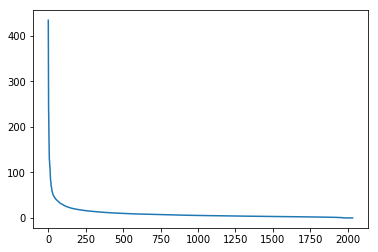

In [114]:
plt.plot(s);

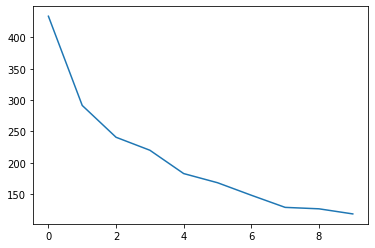

In [52]:
plt.plot(s[:10])

In [55]:
## Now let's look at the most frequent top words for each topics
## Remember each topic includes a little bit of each word in the vocabulary

num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [57]:
show_topics(Vh[:10])    

## apparently this is actually using 2000 topics not the 6 clusters we chose. 
## Not quite sure why but apparently it will be explained later.

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

The first one doesn't seem to map to a topic, but the second one seems to map to `computer graphics`.  
The fourth looks like it's mapping to `religion` or `atheism`.

Note that they are not definitive, but they do make sense... mostly.

We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an **unsupervised algorithm** - which is to say, we never actually told the algorithm how our documents are grouped.

We will return to SVD in **much more detail** later.  For now, the important takeaway is that we have a tool that allows us to exactly factor a matrix into orthogonal columns and orthogonal rows.

Another thing to note is that SVD can result in negative values and this can make it hard to interpret. NMF as the name implies in non-negative and may be easier to interpret.

## Non-negative Matrix Factorization (NMF)

#### Motivation

<img src="images/face_pca.png" alt="PCA on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

A more interpretable approach:

<img src="images/face_outputs.png" alt="NMF on Faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

#### Idea

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be **more easily interpretable** (and this is the reason behind NMF's popularity). 

<img src="images/face_nmf.png" alt="NMF on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix.  NMF is NP-hard and non-unique (unlike SVD).  There are a number of variations on it, created by adding different constraints. 

#### Applications of NMF

- [Face Decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py)
- [Collaborative Filtering, eg movie recommendations](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)
- [Audio source separation](https://pdfs.semanticscholar.org/cc88/0b24791349df39c5d9b8c352911a0417df34.pdf)
- [Chemistry](http://ieeexplore.ieee.org/document/1532909/)
- [Bioinformatics](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0485-4) and [Gene Expression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2623306/)
- Topic Modeling (our problem!)

<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

**More Reading**:

- [The Why and How of Nonnegative Matrix Factorization](https://arxiv.org/pdf/1401.5226.pdf)

### NMF from sklearn

We will use [scikit-learn's implementation of NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html):

In [62]:
m,n=vectors.shape
d=5  # number topics is a hyperparameter 

# Nnlike k-means you can't find a way to optimise k – this is a little unsatisfying

In [63]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [68]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

Again we get `computer graphics`, `space`, `religion` or `athiesm`

### TF-IDF

[Topic Frequency-Inverse Document Frequency](http://www.tfidf.com/) (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

In [69]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [71]:
newsgroups_train.data[10:15]

["a\n\nWhat about positional uncertainties in S-L 1993e?   I assume we know where\nand what Galileo is doing within a few meters.   But without the\nHGA,  don't we have to have some pretty good ideas, of where to look\nbefore imaging?  If the HGA was working,  they could slew around\nin near real time (Less speed of light delay).  But when they were\nimaging toutatis????  didn't someone have to get lucky on a guess to\nfind the first images?   \n\nAlso, I imagine S-L 1993e will be mostly a visual image.  so how will\nthat affect the other imaging missions.  with the LGA,  there is a real\ntight allocation of bandwidth.   It may be premature to hope for answers,\nbut I thought i'd throw it on the floor.",
 "I would like to program Tseng ET4000 to nonstandard 1024x768 mode by\nswitching to standard 1024x768 mode using BIOS and than changing some\ntiming details (0x3D4 registers 0x00-0x1F) but I don't know how to\nselect 36 MHz pixel clock I need. The BIOS function selects 40 MHz.\n\nIs t

In [72]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [74]:
show_topics(H1)

# Note the fourth one is pretty weird but third looks good 

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

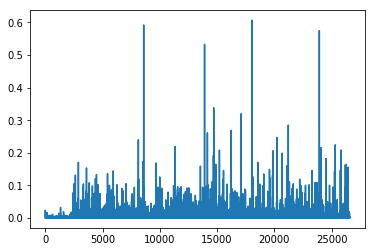

In [122]:
plt.plot(clf.components_[0])

In [99]:
clf.reconstruction_err_

43.71292605795277

### NMF in summary

Benefits: Fast and easy to use!

Downsides: took years of research and expertise to create

Notes:
- For NMF, matrix needs to be at least as tall as it is wide, or we get an error with fit_transform
- Can use df_min in CountVectorizer to only look at words that were in at least k of the split texts

## Truncated SVD

We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD? Yes there is! It's called truncated SVD.  We are just interested in the vectors corresponding to the **largest** singular values.

<img src="images/svd_fb.png" alt="" style="width: 80%"/>

(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

#### Shortcomings of classical algorithms for decomposition:

- Matrices are "stupendously big"
- Data are often **missing or inaccurate**.  Why spend extra computational resources when imprecision of input limits precision of the output?
- **Data transfer** now plays a major role in time of algorithms.  Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
- Important to take advantage of **GPUs**.

(source: [Halko](https://arxiv.org/abs/0909.4061))

#### Advantages of randomized algorithms:

- inherently stable
- performance guarantees do not depend on subtle spectral properties
- needed matrix-vector products can be done in parallel

(source: [Halko](https://arxiv.org/abs/0909.4061))

### Timing comparison

In [83]:
#1. Nupmpy's linear algebra SVD
%time u, s, v = np.linalg.svd(vectors, full_matrices=False)

CPU times: user 35.8 s, sys: 1.37 s, total: 37.2 s
Wall time: 11.3 s


In [84]:
from sklearn import decomposition

#2. sklearns randomised SVD
%time u, s, v = decomposition.randomized_svd(vectors, 10)

CPU times: user 11.2 s, sys: 2.23 s, total: 13.4 s
Wall time: 4.41 s


In [85]:
import fbpca

#3. Facebooks randomised SVD (PCA)
%time u, s, v = fbpca.pca(vectors, 10)

CPU times: user 3.99 s, sys: 773 ms, total: 4.76 s
Wall time: 1.58 s


For more on randomized SVD, check out my [PyBay 2017 talk](https://www.youtube.com/watch?v=7i6kBz1kZ-A&list=PLtmWHNX-gukLQlMvtRJ19s7-8MrnRV6h6&index=7).

For significantly more on randomized SVD, check out the [Computational Linear Algebra course](https://github.com/fastai/numerical-linear-algebra).

In the Computational Linear Algebra course (and repo) there are instructions for how to convert the decomposed  matrices in this notebook to .csv files that can be viewed in .numbers

## End

